# IEEE Fraud Detection - EDA Notebook

## 🔧 **1. ЭТАПЫ ОБРАБОТКИ ДАННЫХ**

### 1.1. **Сбор и отбор данных**
- Соберите **все доступные источники**, включая:
  - Транзакционные логи (входящие/исходящие операции);
  - Логины, авторизации, IP, геолокация;
  - Метаданные устройства;
  - История аккаунта, поведенческие паттерны.
- Отфильтруйте **нерелевантные данные**: удалите тестовые записи, данные с нулевым ID, дублирующиеся строки и т.д.
- Удалите **утечки информации** (например, переменные, которые появляются *после* метки "мошенничество").

### 1.2. **Очистка данных**
- Обработка **пропущенных значений**:
  - Замените пропуски в числовых переменных на медиану или создайте отдельный бинарный индикатор.
  - В категориальных — добавьте категорию `"missing"` или используйте частотные заполнители.
- Удалите или скорректируйте **аномалии**, если они вызваны техническими ошибками.
- Убедитесь в **корректности временных меток** (формат, часовой пояс, хронологическая целостность).

### 1.3. **Агрегация данных**
- Постройте агрегаты **по пользователю, устройству, IP, BIN-карте и т.д.**:
  - Кол-во транзакций за 1 час / 1 день / 1 неделю;
  - Сумма транзакций, стандартное отклонение, медиана;
  - Доля успешных операций;
  - Средний интервал между транзакциями.

### 1.4. **Нормализация и масштабирование**
- Для моделей, чувствительных к масштабу (логистическая регрессия, нейронные сети):
  - Примените `StandardScaler` или `RobustScaler`.
- Для деревьев и бустинга нормализация **не обязательна**, но полезна для стабильности на длинных числовых признаках.

---

## ⚖️ **2. РАБОТА С НЕСБАЛАНСИРОВАННЫМИ ВЫБОРКАМИ**

Мошенничество — редкое событие (обычно <1%).

### 2.1. **Подходы к балансировке:**
- **Undersampling** — случайное удаление части честных примеров;
- **Oversampling (например, SMOTE)** — генерация новых мошеннических записей;
- **ClusterCentroids / TomekLinks** — интеллектуальные методы балансировки;
- **Стратифицированная разбивка** на train/test;
- Используйте **взвешивание классов** (`class_weight="balanced"` в sklearn) — особенно в логистической регрессии и нейронках.

### 2.2. **Не изменяйте test-выборку!**
- Балансировка должна производиться **только** на тренировочных данных.

---

## 🧠 **3. ГЕНЕРАЦИЯ ФИЧЕЙ (FEATURE ENGINEERING)**

### 3.1. **Временные фичи**
- `time_since_last_transaction`, `time_until_next_transaction`;
- `hour_of_day`, `day_of_week`, `is_weekend`, `is_night`;
- `session_duration`, `transactions_per_session`;
- Флаг: `is_first_transaction`, `is_repeat_user`.

### 3.2. **Поведенческие фичи**
- Средний чек за последние N операций;
- Доля операций выше 90-го перцентиля пользователя;
- Отклонение текущей транзакции от медианы;
- Изменение геолокации или IP (`is_new_location`, `is_new_device`);
- Частота смены устройства/браузера/карты.

### 3.3. **Категориальные признаки**
- Кодирование:
  - `Target Encoding` — если высококардинальные признаки;
  - `Frequency Encoding`, `WOE` — для моделей, чувствительных к масштабу;
  - `One-Hot` — для деревьев, если низкое число категорий.

### 3.4. **Групповые признаки**
- Агрегации по:
  - `user_id`, `device_id`, `merchant_id`, `card_id`, `IP`;
  - С учетом окна времени (`rolling window`).

---

## ✅ **4. ВАЛИДАЦИЯ МОДЕЛИ В УСЛОВИЯХ РЕДКИХ СОБЫТИЙ**

### 4.1. **Метрики**
- **Precision, Recall, F1-score** (важнее Accuracy!);
- **ROC-AUC и PR-AUC** (особенно важно смотреть PR-AUC на несбалансированных данных);
- **Lift-curve**, **KS-statistics** для оценки отделения классов.

### 4.2. **Временная кросс-валидация**
- Используйте **TimeSeriesSplit** или rolling window валидацию;
- Не допускайте утечек из будущего — **train < test** по времени;
- Не миксуйте транзакции одного пользователя между train/test.

### 4.3. **Out-of-sample тест**
- Храните финальную отложенную выборку **на потом** — не трогайте её во время обучения.

---

## 🚫 **5. РАСПРОСТРАНЕННЫЕ ОШИБКИ И КАК ИХ ИЗБЕЖАТЬ**

| Ошибка | Как избежать |
|-------|--------------|
| **Утечка информации** (data leakage) | Не используйте фичи, появившиеся после метки (например, chargeback через 2 дня). |
| **Микс данных между пользователями в валидации** | Валидация должна учитывать user/session split. |
| **Неверное кодирование категорий** | Кешируйте трансформеры. Fit — только на train! |
| **Слишком агрессивная балансировка** | Проверяйте, чтобы не потерять важную статистику из "честных" примеров. |
| **Оценка по Accuracy** | Используйте F1, Precision/Recall, особенно при сильном дисбалансе. |
| **Случайная CV при временных данных** | Только временная валидация! |

## 🧾 Описание датасета IEEE Fraud Detection

Этот датасет был создан в рамках соревнования на Kaggle совместно с компанией **Vesta Corporation**, поставщиком решений для цифровой безопасности.  
**Цель:** спрогнозировать, является ли онлайн-транзакция мошеннической (целевая переменная `isFraud`).

---

## 📁 Структура датасета

### 🔹 Обучающая выборка
- `train_transaction.csv` — данные о транзакциях
- `train_identity.csv` — данные об устройстве, IP, браузере, ОС и пр., используемых во время транзакции

### 🔹 Тестовая выборка
- `test_transaction.csv`
- `test_identity.csv`

Обе таблицы соединяются по колонке `TransactionID`.

---

## 🎯 Целевая переменная
- `isFraud` — бинарный флаг:
  - `1`: транзакция — мошенническая
  - `0`: транзакция — легитимная

---

## 🧩 Признаки

### 📦 Transaction Features

| Признак           | Описание |
|-------------------|----------|
| `TransactionID`   | Уникальный ID транзакции |
| `TransactionDT`   | Временная метка (в секундах от некой базовой точки) |
| `TransactionAMT`  | Сумма транзакции (в долларах США) |
| `ProductCD`       | Код продукта |
| `card1`-`card6`   | Информация о платёжной карте: ID карты, тип, банк, страна и т.д. |
| `addr1`, `addr2`  | Географическая информация (адрес, штат и т.д.) |
| `dist1`, `dist2`  | Расстояние от пользователя до магазина или устройства |
| `P_emaildomain`, `R_emaildomain` | Email-домен покупателя и получателя |
| `C1`–`C14`        | Различные счётчики, связанные с транзакциями (например, кол-во карт, устройств, адресов) |
| `D1`–`D15`        | Временные дельты — количество дней с последней транзакции и т.д. |
| `M1`–`M9`         | Бинарные флаги сопоставления (например, совпадает ли адрес доставки и биллинга) |
| `V1`–`V339`       | Скрытые признаки, созданные системой Vesta (feature engineering) |

---

### 🧠 Identity Features

| Признак           | Описание |
|-------------------|----------|
| `DeviceType`      | Тип устройства (desktop / mobile) |
| `DeviceInfo`      | Информация об устройстве (например, модель или браузер) |
| `id_12`–`id_38`   | Признаки, связанные с IP, прокси, ISP, операционной системой и прочими параметрами пользователя. Их конкретное значение скрыто по соображениям конфиденциальности. |

---

## 🗃 Категориальные признаки

Некоторые из них:

- `ProductCD`
- `card1` – `card6`
- `addr1`, `addr2`
- `P_emaildomain`, `R_emaildomain`
- `M1` – `M9`
- `DeviceType`, `DeviceInfo`
- `id_12` – `id_38`

---

## ⚠ Особенности

- **Сильно несбалансированный датасет:** мошеннические транзакции — лишь малая часть выборки.
- **Псевдовременная метка (`TransactionDT`)** — может использоваться для создания временных признаков.
- **Много пропусков и выбросов** — важно тщательно обрабатывать данные.
- **Скрытые признаки `Vxxx`** — важно использовать отброс шума и методы отбора признаков.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)


# Загрузка данных
train_transaction = pd.read_csv("../data/ieee-fraud-detection/train_transaction.csv")

#train_transaction.head()

train_identity = pd.read_csv("../data/ieee-fraud-detection/train_identity.csv")
#train_identity.head()

# Объединение по TransactionID
df = train_transaction.merge(train_identity, on="TransactionID", how="left")

# Загрузка данных
#df = pd.read_csv("ieee_fraud_detection_merged_sample.csv")




In [25]:
import pandas as pd

def missing_values_summary(df):
    missing = df.isnull().sum()
    percent = (missing / len(df)) * 100
    dtypes = df.dtypes
    summary = pd.DataFrame({
        'Missing Values': missing,
        'Percent Missing': percent,
        'Dtype': dtypes
    })
    summary = summary[summary['Missing Values'] > 0]
    summary = summary.sort_values(by='Percent Missing', ascending=False)
    return summary


In [26]:
# Первые строки
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [27]:
df.shape

(590540, 434)

In [28]:
# Основная информация
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


In [29]:
df.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,421571.000000,421571.000000,421571.000000,421571.00000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,421571.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,513444.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,501376.000000,590226.000000,590226.00000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.000000,590226.0000

In [30]:
# Пропущенные значения
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing.head(20)


id_24    585793
id_25    585408
id_07    585385
id_08    585385
id_21    585381
id_26    585377
id_27    585371
id_23    585371
id_22    585371
dist2    552913
D7       551623
id_18    545427
D13      528588
D14      528353
D12      525823
id_03    524216
id_04    524216
D6       517353
id_33    517251
id_10    515614
dtype: int64

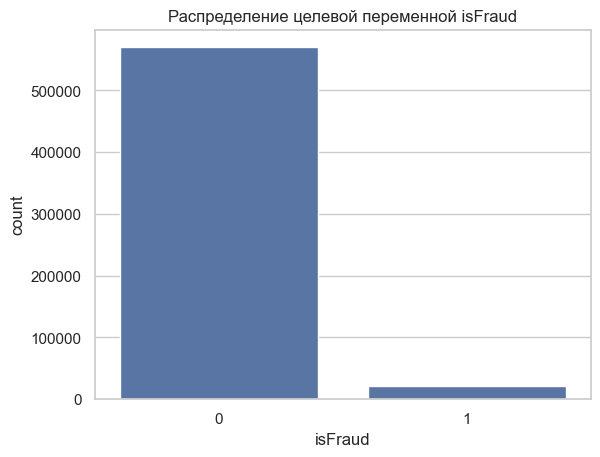

In [7]:
# Распределение isFraud
sns.countplot(data=df, x="isFraud")
plt.title("Распределение целевой переменной isFraud")
plt.show()


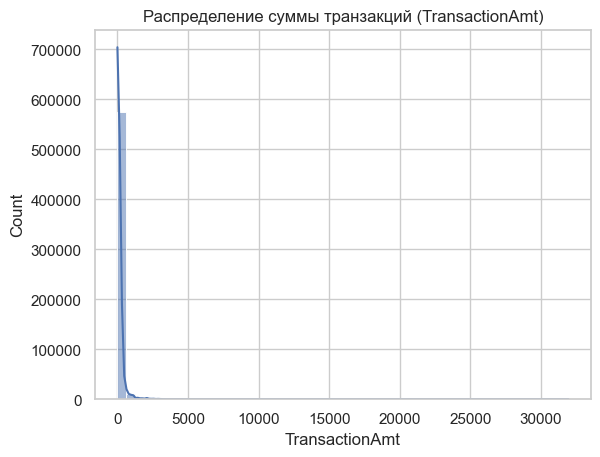

In [8]:
# Пример анализа TransactionAMT
sns.histplot(df['TransactionAmt'], bins=50, kde=True)
plt.title("Распределение суммы транзакций (TransactionAmt)")
plt.show()


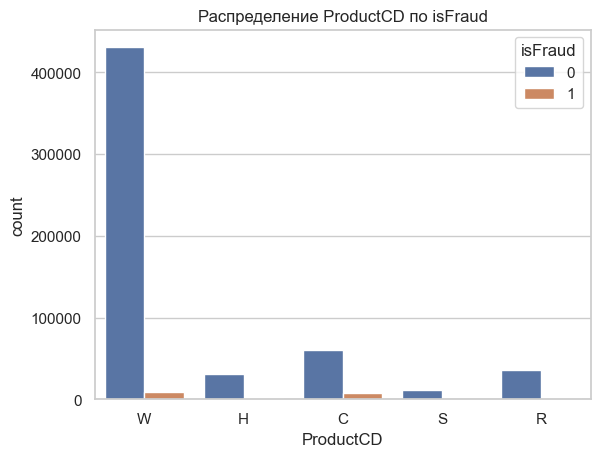

In [9]:
# Категориальный признак: ProductCD
sns.countplot(data=df, x="ProductCD", hue="isFraud")
plt.title("Распределение ProductCD по isFraud")
plt.show()


In [10]:
# Пример:
missing_summary = missing_values_summary(df)
missing_summary #.to_csv('missing.csv')

,Missing Values,Percent Missing,Dtype
id_24,585793,99.196159,float64
id_25,585408,99.130965,float64
id_07,585385,99.127070,float64
id_08,585385,99.127070,float64
id_21,585381,99.126393,float64
...,...,...,...
V285,12,0.002032,float64
V284,12,0.002032,float64
V280,12,0.002032,float64
V279,12,0.002032,float64


## Очистка данных

In [11]:
import pandas as pd

# Загрузка данных (предположим, что DataFrame называется df)
#df = pd.read_csv('your_data.csv')

# Рассчитываем процент пропущенных значений для каждого столбца
missing_percentage = df.isnull().mean() * 100

# Фильтруем столбцы, у которых меньше 90% пропусков
df_cleaned = df.loc[:, missing_percentage < 90]
df_cleaned

# Сохраняем результат в новый CSV файл (если необходимо)
#df_cleaned.to_csv('cleaned_data.csv', index=False)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN

In [12]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Загрузка данных (предположим, что DataFrame называется df)
#df = pd.read_csv('your_data.csv')
df = df_cleaned

# Рассчитываем процент пропущенных значений для каждого столбца
missing_percentage = df.isnull().mean() * 100

# Фильтруем столбцы, у которых меньше 90% пропусков
df_cleaned = df.loc[:, missing_percentage < 90]

# Разделяем данные на числовые и категориальные столбцы
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Импутация для числовых столбцов (замена пропусков на медиану)
numerical_imputer = SimpleImputer(strategy='median')
df_cleaned[numerical_cols] = numerical_imputer.fit_transform(df_cleaned[numerical_cols])

# Импутация для категориальных столбцов (замена пропусков на наиболее частое значение)
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_cleaned[categorical_cols] = categorical_imputer.fit_transform(df_cleaned[categorical_cols])
df_cleaned

# Сохраняем результат в новый CSV файл (если необходимо)
#df_cleaned.to_csv('cleaned_data_imputed.csv', index=False)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000.0,0.0,86400.0,68.50,W,13926.0,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,37.875,0.666666,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,117.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.0,125800.5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,341.0,472.0,Found,Found,Windows 10,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,F,desktop,Windows
1,2987001.0,0.0,86401.0,29.00,W,2755.0,404.0,150.0,masterc

In [13]:
missing_summary = missing_values_summary(df_cleaned)
missing_summary #.to_csv('missing.csv')

,Missing Values,Percent Missing,Dtype


In [14]:
df_cleaned.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_32
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.00000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590

## Кодирование категориальных переменных

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Загрузка данных
#df = pd.read_csv('your_data.csv')
df = df_cleaned

# Проверяем типы данных
print(df.dtypes)

# Если в числовых столбцах есть текстовые значения, можно преобразовать их в числовые или удалить.
# Например, если колонка 'category' - категориальная, можно ее закодировать.
categorical_cols = df.select_dtypes(include=['object']).columns

# Применяем LabelEncoder для категориальных признаков
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))  # Преобразуем в строки перед кодированием

df_cleaned = df


TransactionID     float64
isFraud           float64
TransactionDT     float64
TransactionAmt    float64
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 422, dtype: object


## Базовая модель

In [16]:
!pip install boto3

In [17]:
!pip install mlflow

In [92]:
import requests
import os
from dotenv import load_dotenv

load_dotenv()  # Загружает переменные из .env

# Параметры запроса
data = {
    "grant_type": "password",
    "client_id": os.getenv("OAUTH_CLIENT_ID"),
    "client_secret": os.getenv("OAUTH_CLIENT_SECRET"),
    "username": os.getenv("MLFLOW_USERNAME"),
    "password": os.getenv("MLFLOW_PASSWORD"),
    "scope": "openid"
}

# Отправка POST-запроса
response = requests.post(os.getenv("OAUTH_URL"), data=data)

# Проверка статуса ответа
if response.status_code == 200:
    # Если запрос успешен, извлекаем токен
    token = response.json().get("access_token")
    print(f"JWT Token: {token}")
else:
    # Если ошибка, выводим описание ошибки
    print(f"Error: {response.status_code}")
    print(response.json())

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): keycloak.openidealab.com:443
DEBUG:urllib3.connectionpool:https://keycloak.openidealab.com:443 "POST /realms/openidealab-ml/protocol/openid-connect/token HTTP/1.1" 200 4000


JWT Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJWT2xEWVppbU8tMGkzeDlMN2c5QWR5WFJGZEhDX1M0WldQN1MwVnJibFFjIn0.eyJleHAiOjE3NDQ4NDIzOTEsImlhdCI6MTc0NDg0MDU5MSwianRpIjoiODcxNzlmNGYtOWE3My00ODE5LWFkOTgtNmUwYTBkMDMwYzY2IiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5vcGVuaWRlYWxhYi5jb20vcmVhbG1zL29wZW5pZGVhbGFiLW1sIiwiYXVkIjpbImp1cHl0ZXIiLCJhaXJmbG93IiwiYWNjb3VudCJdLCJzdWIiOiIxOTIxZjBkMi0xMmIxLTRjMGQtODRlNi0xOGE2Yjg5ZTI0NzAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJtbGZsb3ciLCJzZXNzaW9uX3N0YXRlIjoiOTdjYjc5NzMtMGEwNy00M2JjLWFmZjYtMTc3ZjA3NTJhYzAwIiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL21sZmxvdy5vcGVuaWRlYWxhYi5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWp1cHl0ZXIiXX0sInJlc291cmNlX2FjY2VzcyI6eyJqdXB5dGVyIjp7InJvbGVzIjpbInVtYV9wcm90ZWN0aW9uIiwiYWRtaW4iLCJ1c2VyIl19LCJhaXJmbG93Ijp7InJvbGVzIjpbIkFkbWluIl19LCJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZ

In [93]:
import boto3
from dotenv import load_dotenv

load_dotenv()  # Загружает переменные из .env

session = boto3.Session(
    #aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    #aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    #region_name='us-east-1'  # Adjust the region as needed
)
# Подключение к MinIO
s3 = session.resource(
    's3',
    endpoint_url='https://minio-api.openidealab.com',  # Замените на ваш MinIO хост, если отличается
    config=boto3.session.Config(signature_version='s3v4'),
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    #region_name='us-east-1'  # Замените при необходимости
)

# Пример доступа ко всем бакетам в MinIO
#for bucket in s3.buckets.all():
#    print(bucket.name)

# Установка переменных окружения
#os.environ['AWS_ACCESS_KEY_ID'] = credentials.access_key
#os.environ['AWS_SECRET_ACCESS_KEY'] = credentials.secret_key
#os.environ['AWS_SESSION_TOKEN'] = credentials.token  # если требуется (например, MFA)

DEBUG:botocore.hooks:Changing event name from creating-client-class.iot-data to creating-client-class.iot-data-plane
DEBUG:botocore.hooks:Changing event name from before-call.apigateway to before-call.api-gateway
DEBUG:botocore.hooks:Changing event name from request-created.machinelearning.Predict to request-created.machine-learning.Predict
DEBUG:botocore.hooks:Changing event name from before-parameter-build.autoscaling.CreateLaunchConfiguration to before-parameter-build.auto-scaling.CreateLaunchConfiguration
DEBUG:botocore.hooks:Changing event name from before-parameter-build.route53 to before-parameter-build.route-53
DEBUG:botocore.hooks:Changing event name from request-created.cloudsearchdomain.Search to request-created.cloudsearch-domain.Search
DEBUG:botocore.hooks:Changing event name from docs.*.autoscaling.CreateLaunchConfiguration.complete-section to docs.*.auto-scaling.CreateLaunchConfiguration.complete-section
DEBUG:botocore.hooks:Changing event name from before-parameter-buil

In [94]:
import os
import mlflow

import logging

# Устанавливаем уровень логирования для MLflow
logging.basicConfig(level=logging.DEBUG)

os.environ['MLFLOW_TRACKING_URI']= "https://mlflow.openidealab.com"
os.environ['MLFLOW_TRACKING_TOKEN']= token

# Set our tracking server uri for logging
#mlflow.set_tracking_uri(uri="https://mlflow.openidealab.com")
#mlflow.set_tracking_uri(uri="http://localhost:57973")


# Create a new MLflow Experiment
mlflow.set_experiment("IEEE Fraud Detection")

DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "GET /api/2.0/mlflow/experiments/get-by-name?experiment_name=IEEE+Fraud+Detection HTTP/1.1" 200 236


<Experiment: artifact_location='s3://mlflow/2', creation_time=1744813509022, experiment_id='2', last_update_time=1744813509022, lifecycle_stage='active', name='IEEE Fraud Detection', tags={}>

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score


# Загрузка данных
#df = pd.read_csv('your_data.csv')
df = df_cleaned

# Пример: предположим, что целевая переменная называется 'fraud' (1 - мошенничество, 0 - не мошенничество)
X = df.drop(columns=['isFraud'])  # Признаки
y = df['isFraud']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Стандартизация числовых признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание и обучение модели логистической регрессии
mlflow.autolog()

with mlflow.start_run():
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    
    # Прогнозирование на тестовых данных
    y_pred = model.predict(X_test_scaled)
    
    # Оценка качества модели
    recall = recall_score(y_test, y_pred, average='macro')  # Используем 'macro', чтобы рассчитать по всем классам
    print(f"Recall: {recall}")

    # Вычисляем PR AUC
    # Получаем вероятности для положительного класса
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Используем только вероятности для положительного класса

    # Вычисляем PR AUC
    pr_auc = average_precision_score(y_test, y_prob)

    print("Матрица ошибок:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nОтчет по классификации:")
    print(classification_report(y_test, y_pred))

    # Логируем метрику в MLflow
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("pr_auc", pr_auc)

    #mlflow.sklearn.log_model(model, "model")


2025/04/17 00:56:35 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/04/17 00:56:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.
2025/04/17 00:56:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "POST /api/2.0/mlflow/runs/create HTTP/1.1" 200 940
2025/04/17 00:56:36 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
/Users/sergey/Projects/Karpov.Courses/mfdp-fin-fraud-detection/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or 

Recall: 0.6290811973623553
Матрица ошибок:
[[170471    350]
 [  4691   1650]]

Отчет по классификации:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99    170821
         1.0       0.82      0.26      0.40      6341

    accuracy                           0.97    177162
   macro avg       0.90      0.63      0.69    177162
weighted avg       0.97      0.97      0.96    177162



DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "POST /api/2.0/mlflow/runs/log-metric HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "POST /api/2.0/mlflow/runs/log-metric HTTP/1.1" 200 2
DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "GET /api/2.0/mlflow/runs/get?run_uuid=6cf5ab656d274a18b942946d8edef76f&run_id=6cf5ab656d274a18b942946d8edef76f HTTP/1.1" 200 2654
DEBUG:urllib3.connectionpool:https://mlflow.openidealab.com:443 "POST /api/2.0/mlflow/runs/update HTTP/1.1" 200 414


🏃 View run melodic-perch-79 at: https://mlflow.openidealab.com/#/experiments/2/runs/6cf5ab656d274a18b942946d8edef76f
🧪 View experiment at: https://mlflow.openidealab.com/#/experiments/2


# построения ROC-AUC кривой

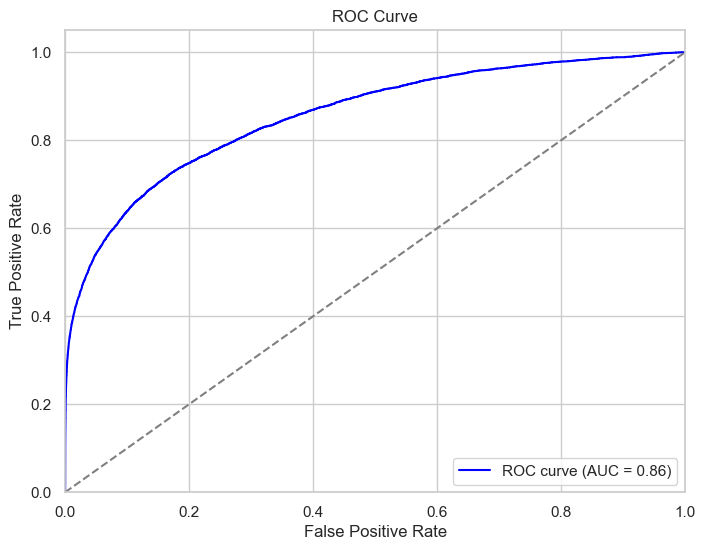

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Получаем вероятности для положительного класса
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Используем только вероятности для положительного класса

# Вычисляем ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Вычисляем AUC
roc_auc = auc(fpr, tpr)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайной модели
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#  построения PR-AUC кривой

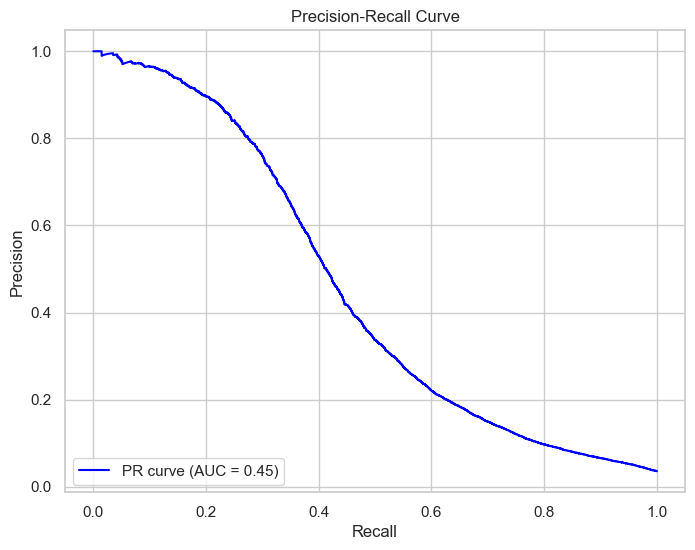

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Получаем вероятности для положительного класса
y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Используем только вероятности для положительного класса

# Вычисляем Precision-Recall кривую
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Вычисляем PR AUC
pr_auc = average_precision_score(y_test, y_prob)

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
